In [1]:
# uv init
# uv pip install ipykernel #for vscode
# %uv pip install numpy pandas matplotlib seaborn


In [2]:
# data seems to be organize in CSV files without extensions
# with the header line and columns of data. Classical pandas DataFrame format

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def load_data(file_path):
    """
    Load data from a CSV file without an extension and format column names.
    
    Parameters:
    file_path (str): Path to the CSV file.
    
    Returns:
    pd.DataFrame: DataFrame containing the loaded data with formatted column names.
    """
    try:
        data = pd.read_csv(file_path, header=0)
        # Remove leading/trailing spaces and replace internal spaces with underscores
        data.columns = [col.strip().replace(' ', '_') for col in data.columns]
        data = data.rename(columns={'y-coordinate': 'y', 'x-coordinate': 'x', 'pressure':'p', 'z-coordinate':'z' ,'x-velocity': 'U', 'y-velocity':'v'})
        data['x_rounded'] = data['x'].round(3)
        data['y_rounded'] = data['y'].round(4)
        data['z_rounded'] = data['z'].round(3)
        return data
    except Exception as e:
        print(f"Error loading data from {file_path}: {e}")
        return None

In [5]:
df = load_data('data/64X24X28 X=1 Z=1 bf=44p5 16')  # Replace 'data.csv' with your actual file path

In [6]:
df.columns

Index(['nodenumber', 'x', 'y', 'z', 'p', 'U', 'v', 'turb-kinetic-energy',
       'turb-diss-rate', 'viscosity-turb', 'x_rounded', 'y_rounded',
       'z_rounded'],
      dtype='object')

Number of unique x_rounded values: 65


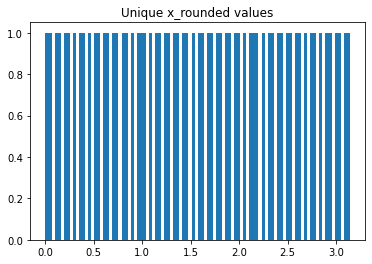

[array([-0.   ,  0.047,  0.102,  0.156,  0.203,  0.251,  0.307,  0.36 ,
        0.405,  0.451,  0.505,  0.555,  0.599,  0.645,  0.699,  0.749,
        0.794,  0.839,  0.893,  0.944,  0.988,  1.033,  1.086,  1.138,
        1.182,  1.227,  1.28 ,  1.332,  1.376,  1.421,  1.474,  1.526,
        1.571,  1.616,  1.668,  1.72 ,  1.765,  1.81 ,  1.861,  1.914,
        1.959,  2.004,  2.055,  2.108,  2.154,  2.198,  2.249,  2.302,
        2.348,  2.392,  2.443,  2.496,  2.542,  2.586,  2.636,  2.69 ,
        2.737,  2.782,  2.835,  2.891,  2.939,  2.985,  3.039,  3.095,
        3.142])]


In [7]:

unique_x = np.sort(df['x_rounded'].unique())
print(f"Number of unique x_rounded values: {len(unique_x)}")

plt.hist(unique_x, bins=100)
plt.title("Unique x_rounded values")
plt.show()
print([unique_x])

Number of unique y_rounded values: 1317


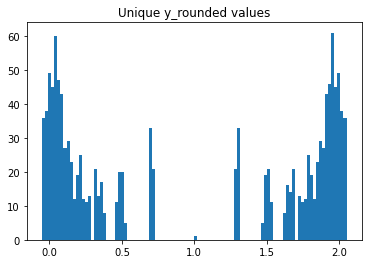

In [8]:
unique_y = df['y_rounded'].unique()
print(f"Number of unique y_rounded values: {len(unique_y)}")

plt.hist(unique_y,bins=100)
plt.title("Unique y_rounded values")
plt.show()

In [9]:
pi=np.pi
amp=0.05
pi_div=2
lam=pi/8
theta_target=pi/pi_div
length=pi
bf=44.5
u_tau=1
nu=float(1/300)
x_target=theta_target*lam*0.5/pi
#for the no interpolation section
periods_number=round(pi/lam)
node_period=round((len(unique_x)-1)/periods_number)
print(node_period)
node_target=round((theta_target*0.5/pi)*node_period)
print(node_target)
node_sel=unique_x[node_target::node_period]
#for the interpolation section
x_sel=list(np.arange(x_target, length  , lam))
x_sel=np.round(x_sel, 5)
print([node_sel])
print([x_sel])


8
2
[array([0.102, 0.505, 0.893, 1.28 , 1.668, 2.055, 2.443, 2.835])]
[array([0.09817, 0.49087, 0.88357, 1.27627, 1.66897, 2.06167, 2.45437,
       2.84707])]


Number of unique z_rounded values: 1


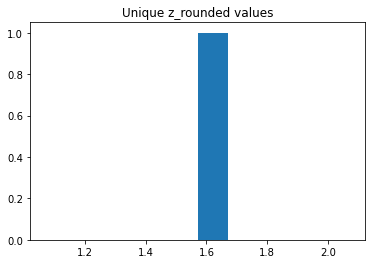

In [10]:
unique_z = df['z_rounded'].unique()
print(f"Number of unique z_rounded values: {len(unique_z)}")

plt.hist(unique_z)
plt.title("Unique z_rounded values")
plt.show()

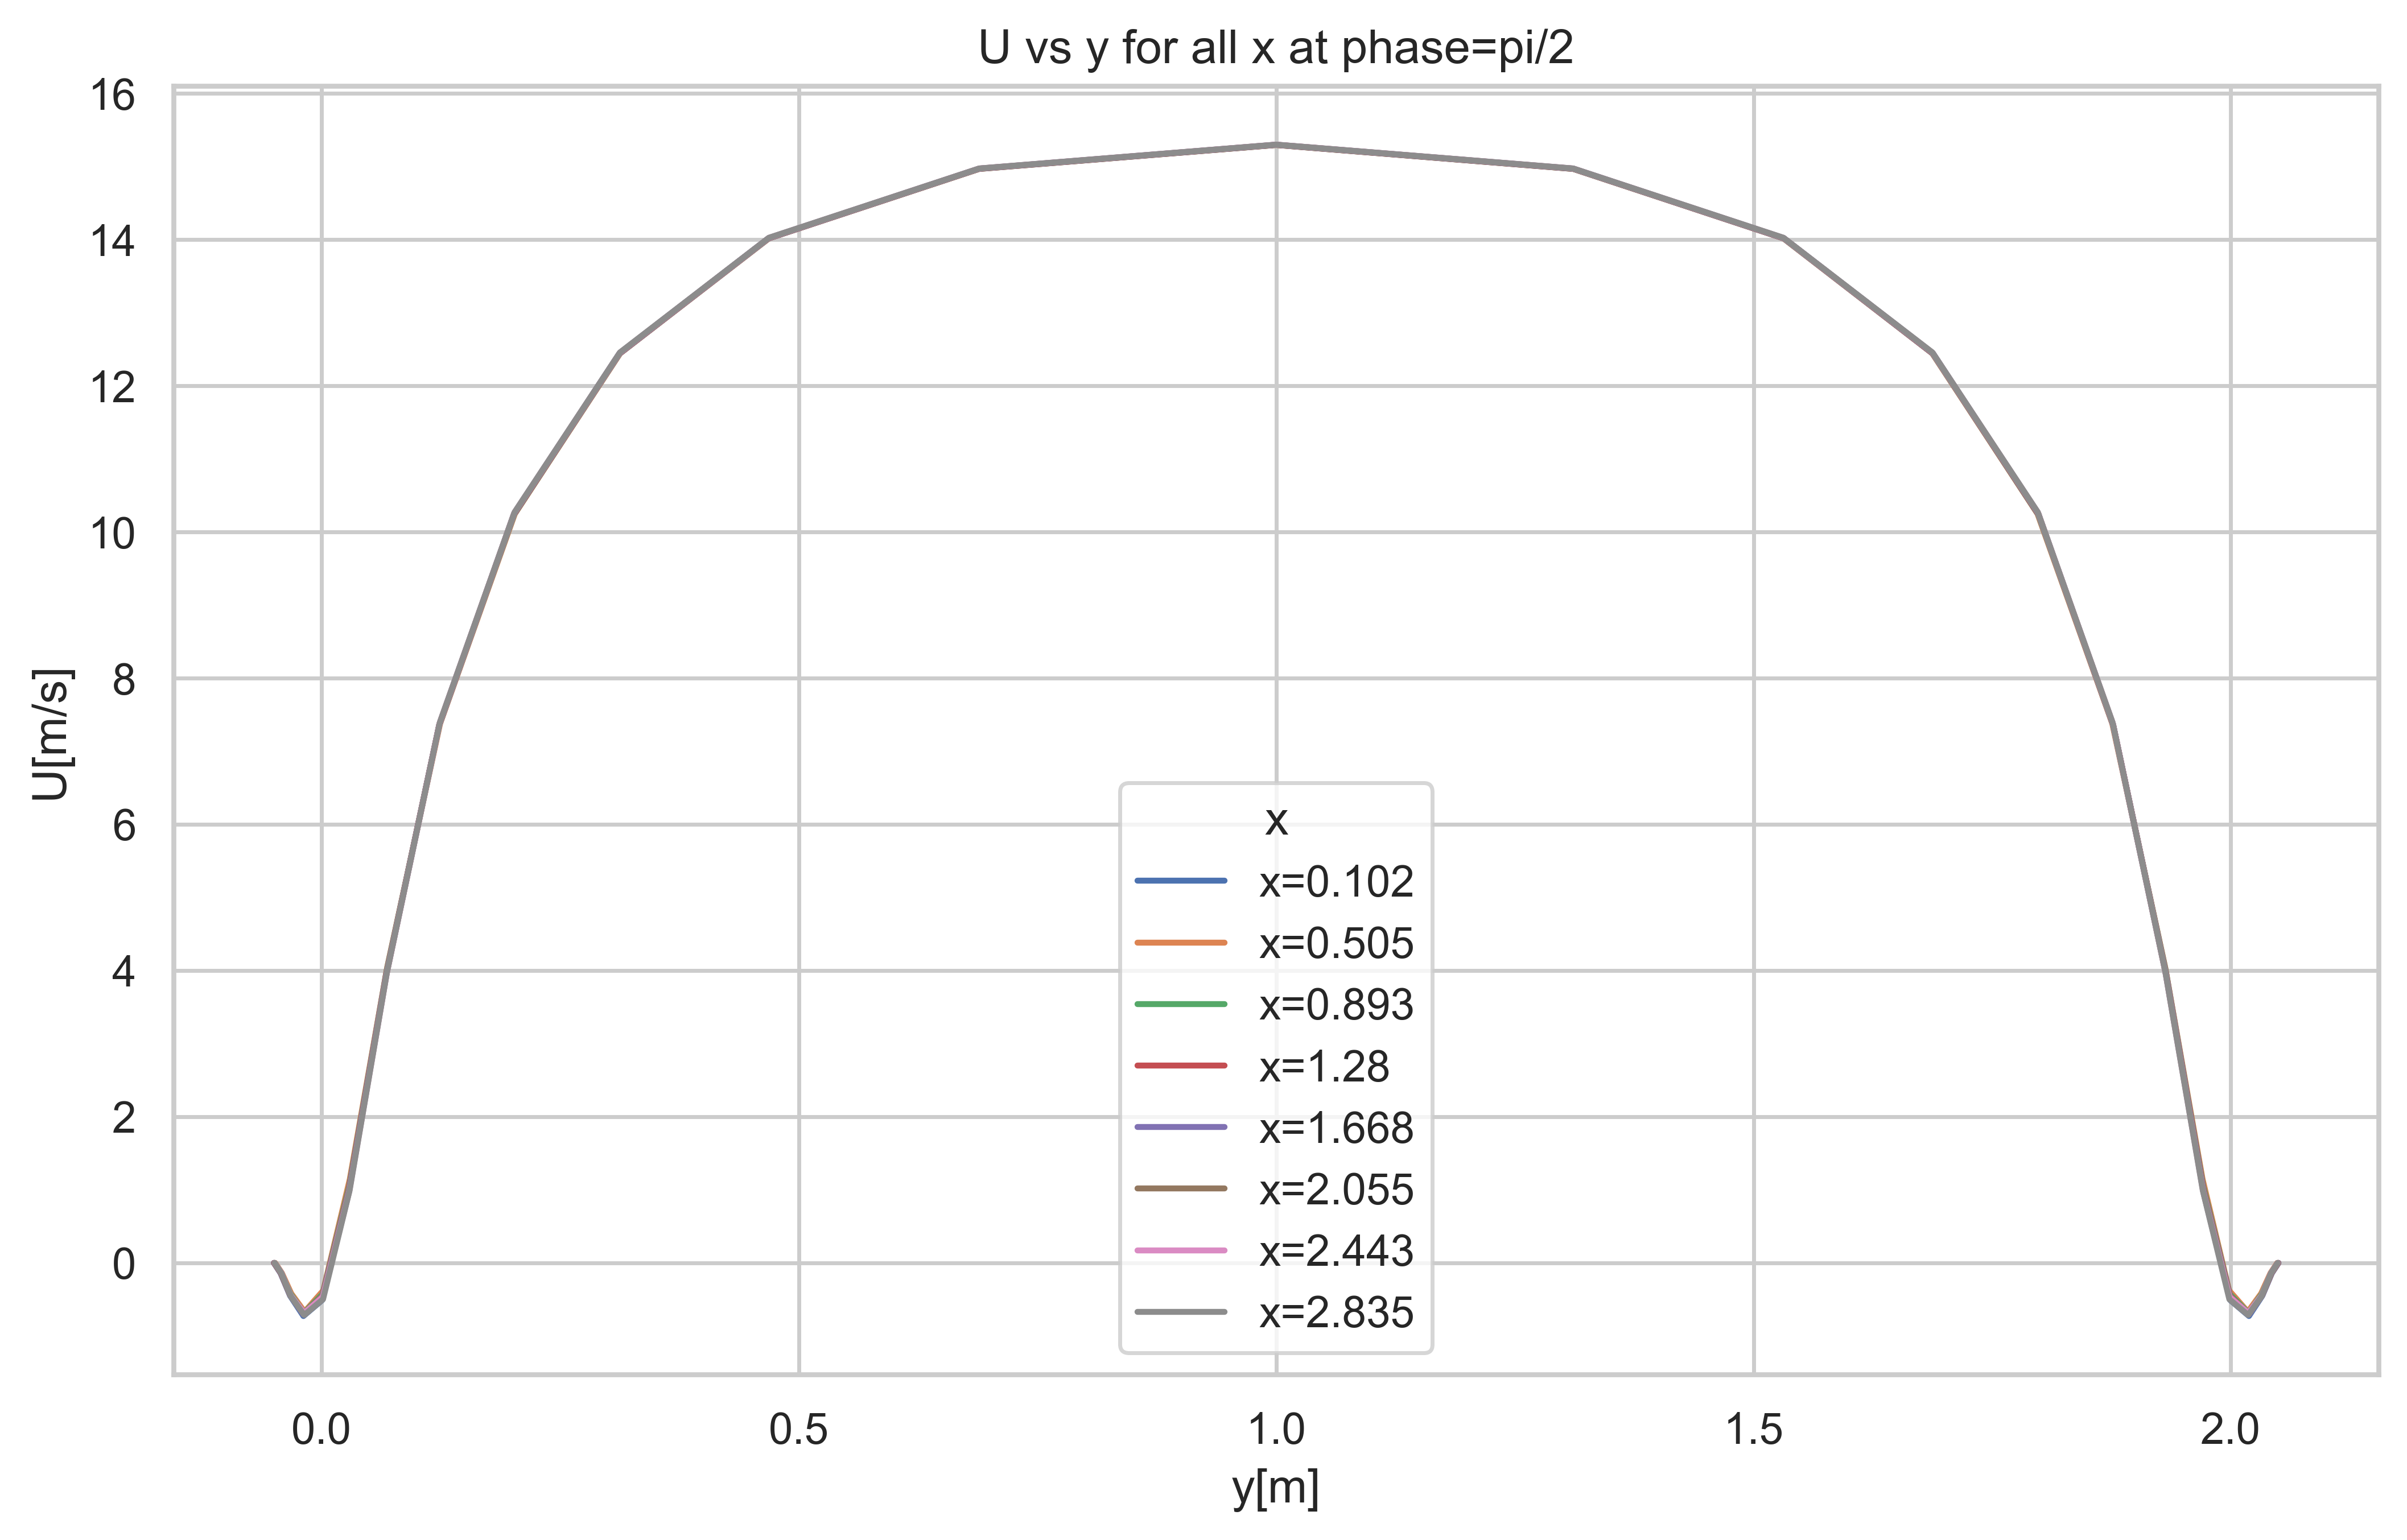

In [11]:
#no interpolatin involved
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6),dpi=500)


for x_val in sorted(node_sel):
    subset = df[df['x_rounded'] == x_val]
    sns.lineplot(x='y', y='U', data=subset, label=f'x={x_val}')

plt.title(f'U vs y for all x at phase=pi/{pi_div}')
plt.xlabel('y[m]')
plt.ylabel('U[m/s]')
plt.legend(title='x')
plt.show()

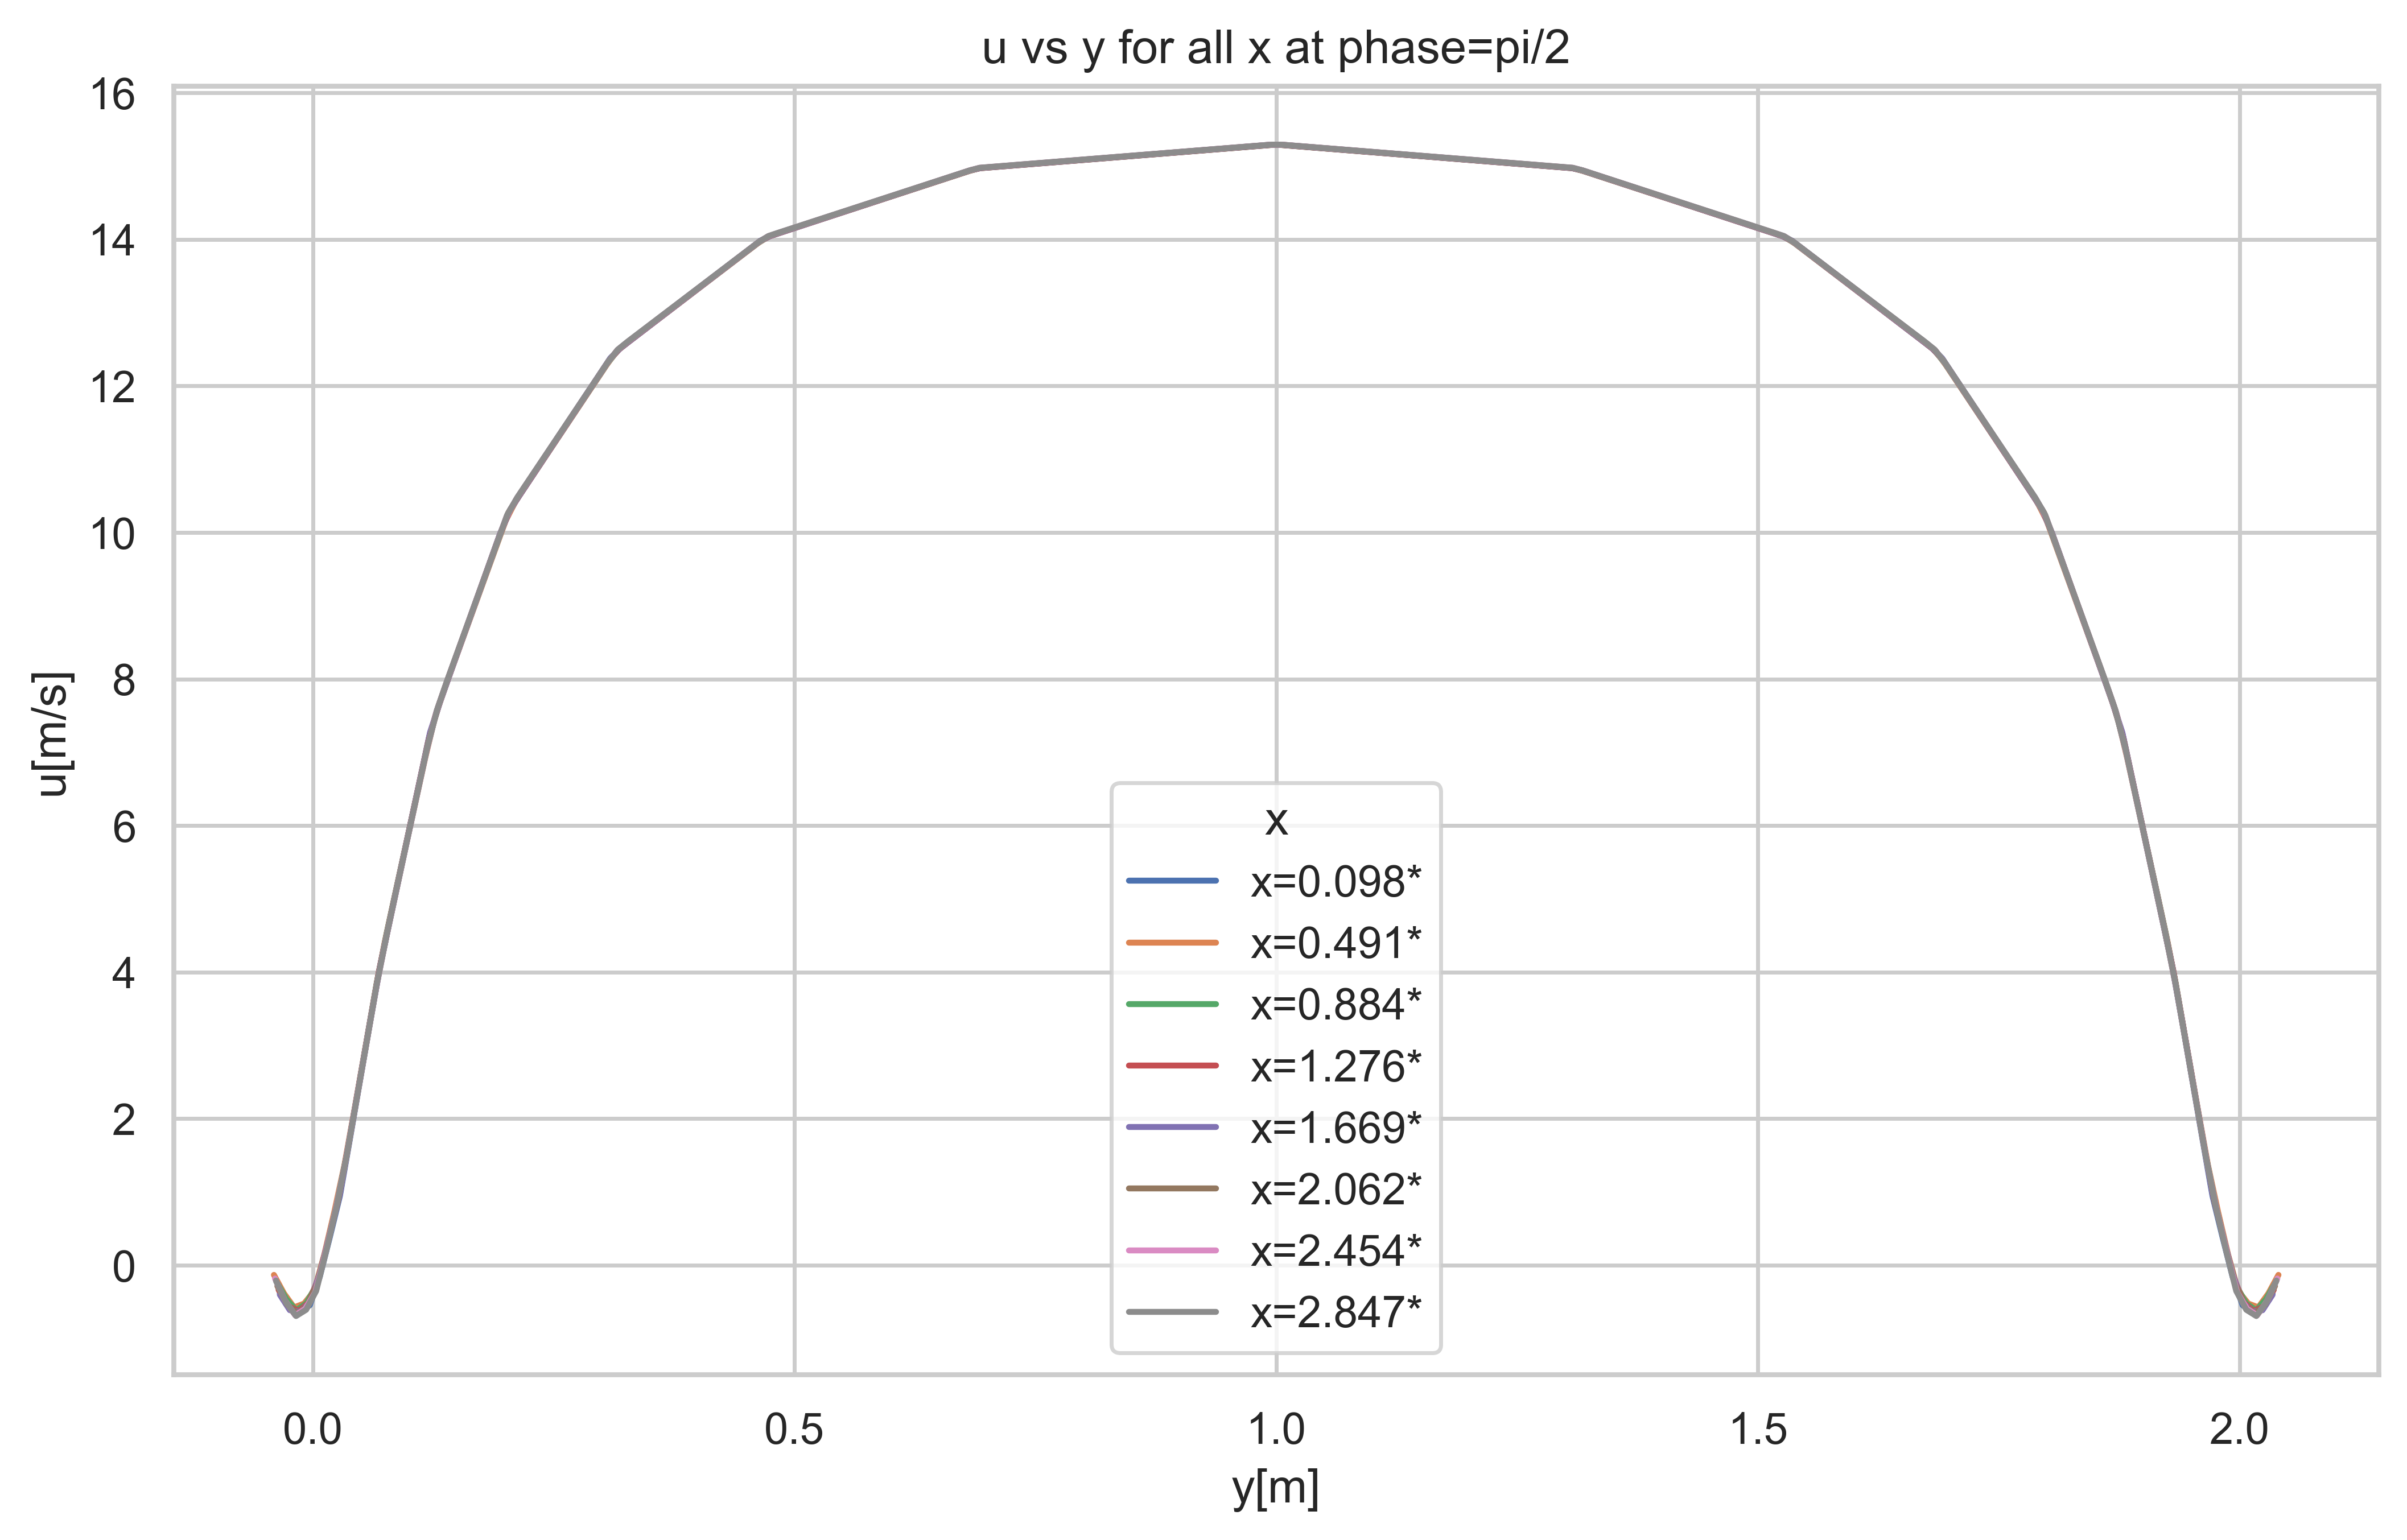

In [12]:
#interpolation in y and then x 
from scipy.interpolate import interp1d
plt.figure(figsize=(10, 6),dpi=500)

for x_val in sorted(x_sel):
    if x_val in unique_x:
        subset = df[df['x_rounded'] == x_val]
        sns.lineplot(x='y', y='U', data=subset, label=f'x={x_val:.3f}')

    else:
        x_below = unique_x[unique_x < x_val].max(initial=None)
        x_above = unique_x[unique_x > x_val].min(initial=None)

        if x_below is not None and x_above is not None:
            sub_below = df[df['x_rounded'] == x_below].sort_values('y')
            sub_above = df[df['x_rounded'] == x_above].sort_values('y')

            # Build interpolators for U vs y at x_below and x_above
            f_below = interp1d(sub_below['y'], sub_below['U'], bounds_error=False, fill_value=np.nan)
            f_above = interp1d(sub_above['y'], sub_above['U'], bounds_error=False, fill_value=np.nan)

            # Define a common y-grid (e.g. union or fine linspace)
            y_interp = np.linspace(
                max(sub_below['y'].min(), sub_above['y'].min()),
                min(sub_below['y'].max(), sub_above['y'].max()),
                200
            )

            # Interpolate U at both x locations
            U1 = f_below(y_interp)
            U2 = f_above(y_interp)

            # Linear interpolation in x direction
            U_interp = U1 + (U2 - U1) * (x_val - x_below) / (x_above - x_below)

            interp_df = pd.DataFrame({'y': y_interp, 'U': U_interp})
            sns.lineplot(x='y', y='U', data=interp_df, label=f'x={x_val:.3f}*')
plt.title(f'u vs y for all x at phase=pi/{pi_div}')
plt.xlabel('y[m]')
plt.ylabel('u[m/s]')
plt.legend(title='x')
plt.grid(True)
plt.show()

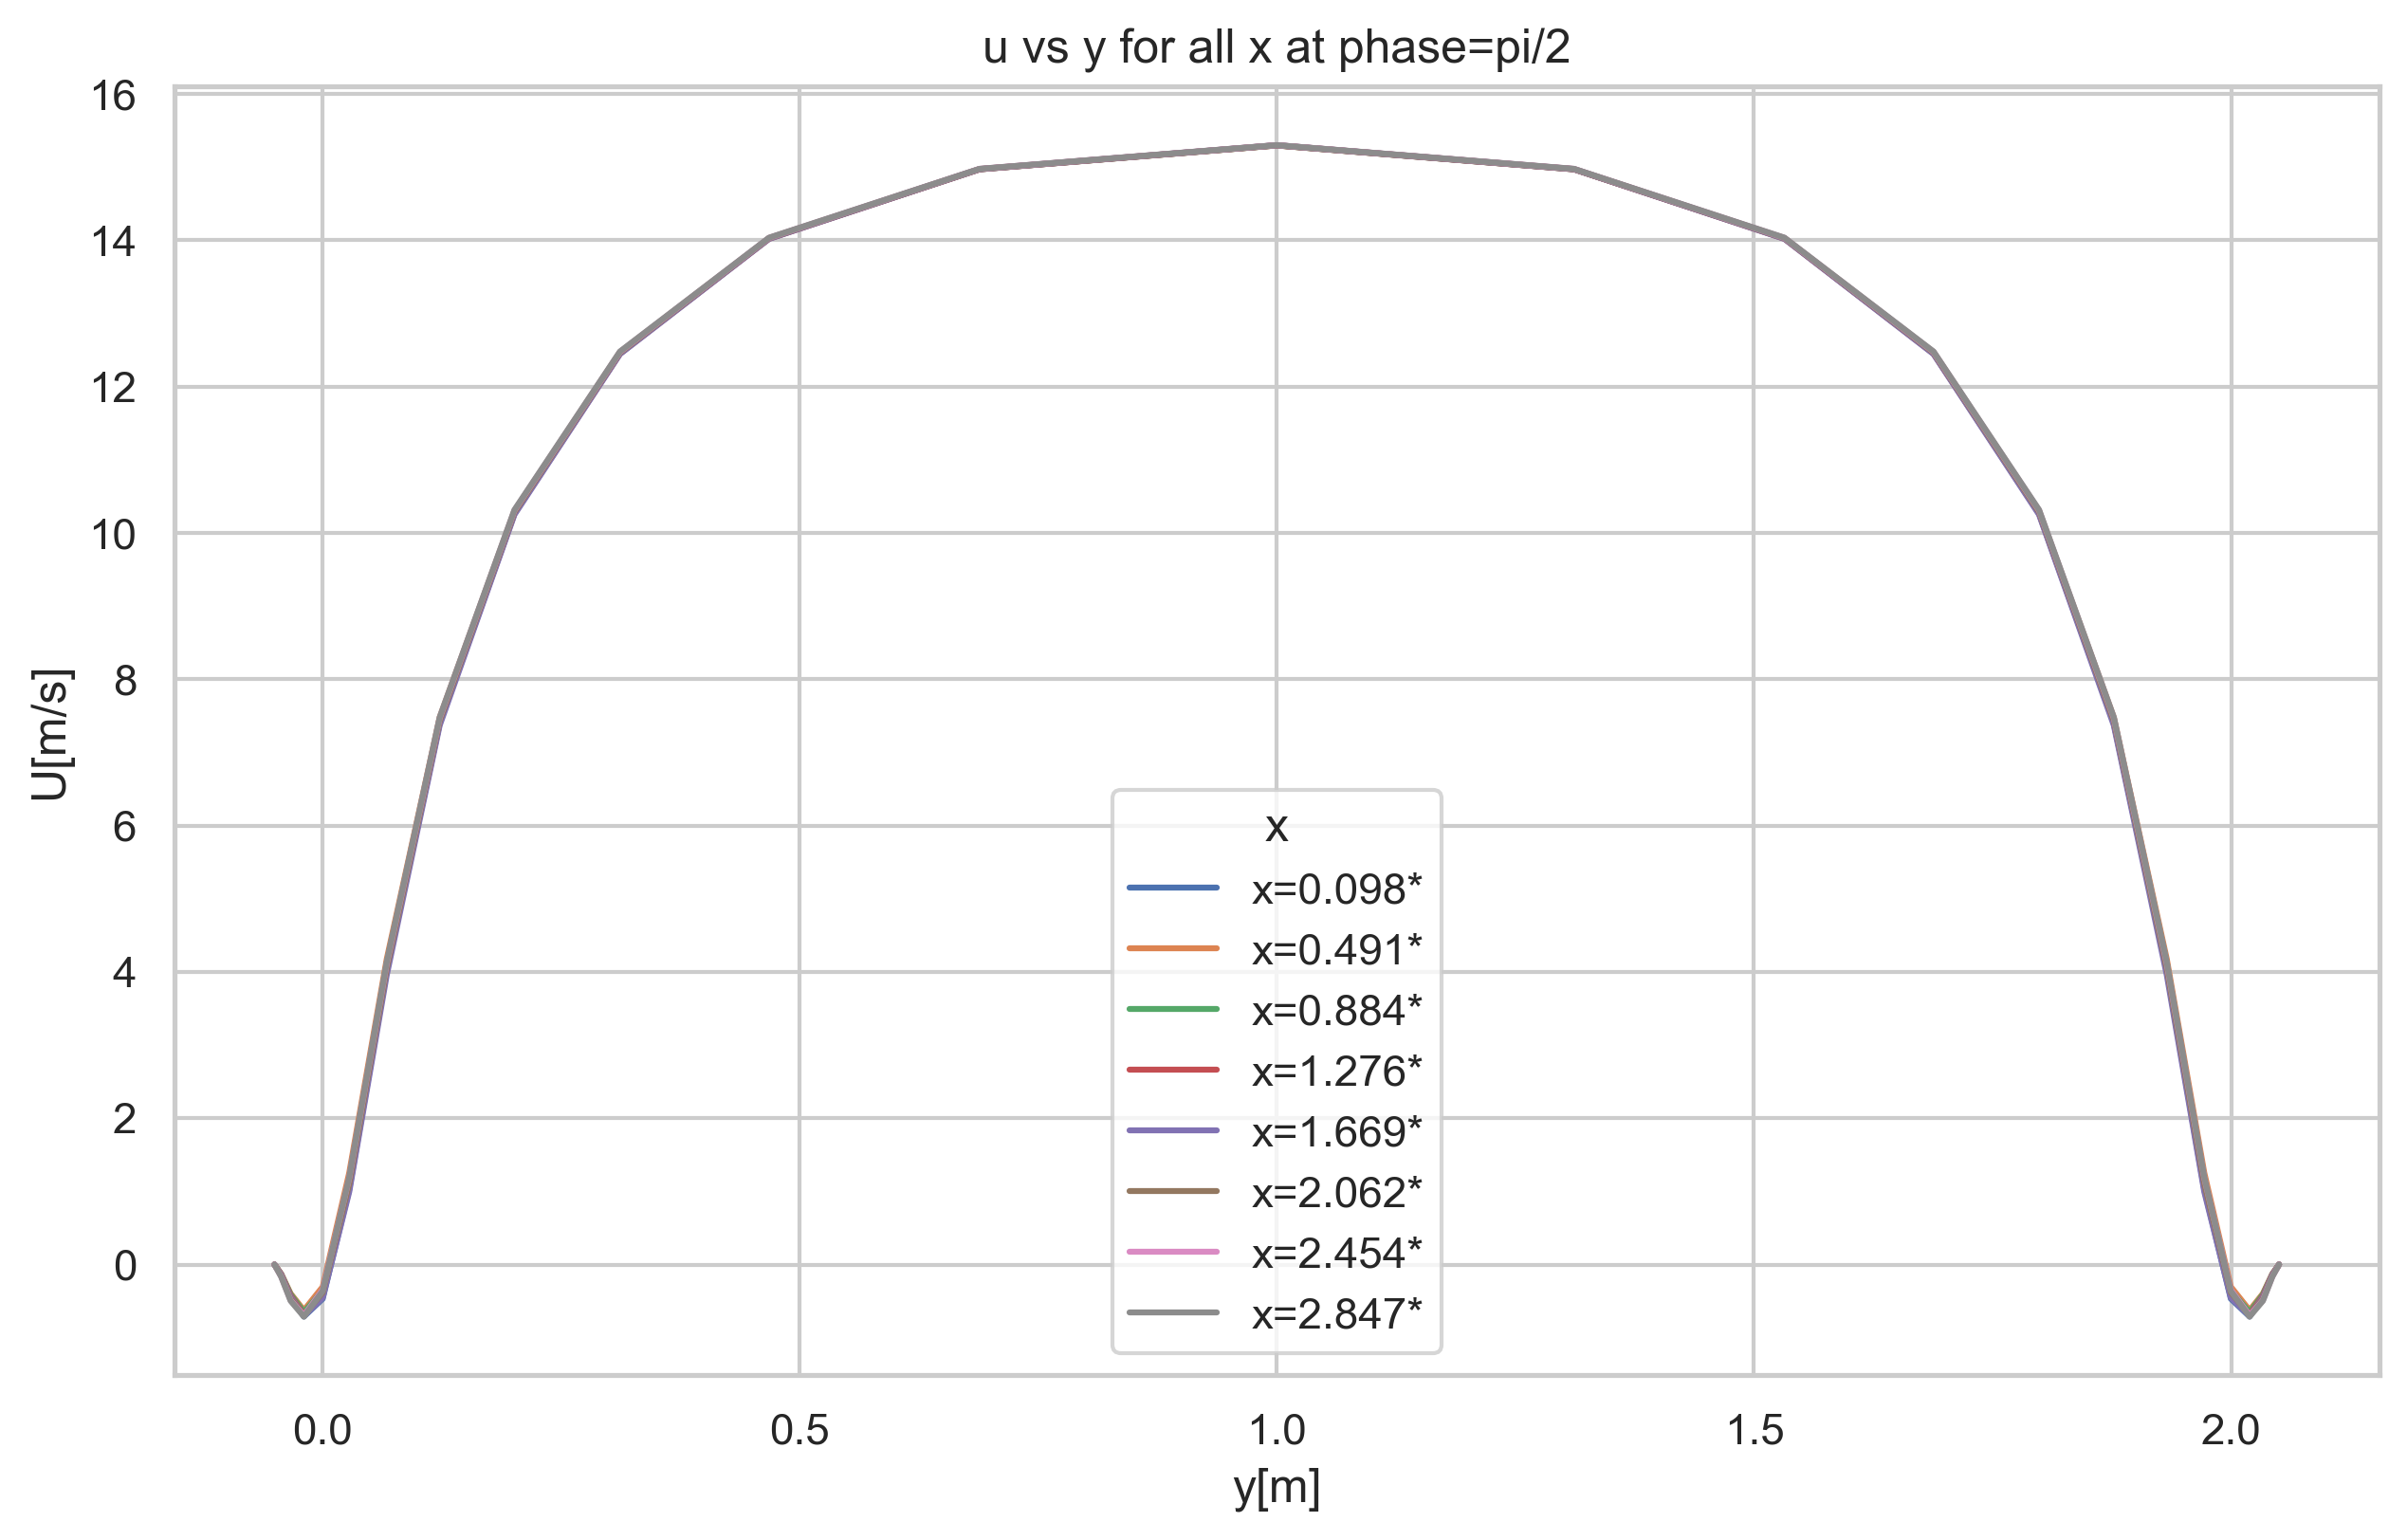

In [13]:
#interpolation in x only by the corresponding node(chosen)
def build_symmetric_y_grid(y_min, y_max, l1, r, n):
    spacing_half = [l1 * r**(i) for i in range(n)]
    spacing = np.array(spacing_half + spacing_half[::-1])
    spacing_scaled = spacing / spacing.sum() * (y_max - y_min)
    y_points = np.cumsum(spacing_scaled) + y_min  # Start from y_min directly
    y_points = np.insert(y_points, 0, y_min)
    return y_points  # Remove the insert operation

def interpolate_U_at_x(x_val, df, unique_x, l1, r, n):
    x_below = unique_x[unique_x < x_val].max(initial=None)
    x_above = unique_x[unique_x > x_val].min(initial=None)
    if x_below is None or x_above is None:
        return None

    sub_below = df[df['x_rounded'] == x_below].sort_values('y').reset_index(drop=True)
    sub_above = df[df['x_rounded'] == x_above].sort_values('y').reset_index(drop=True)

    y_min = -0.05 * np.sin(16 * x_val)
    y_max =  2.0 + 0.05 * np.sin(16 * x_val)
    y_interp = build_symmetric_y_grid(y_min, y_max, l1, r, n)

    if len(sub_below) < 2*n+1 or len(sub_above) < 2*n+1:
        return None

    U_below = sub_below['U']
    U_above = sub_above['U']
    U_interp = U_below + (U_above - U_below) * (x_val - x_below) / (x_above - x_below)

    return pd.DataFrame({'y': y_interp, 'U': U_interp})
# === User Inputs ===
r = 1.4121    # geometric growth ratio
l1 = 0.00666  # first wall spacing
n = 12     # number of steps per half channel
x_sel = sorted(x_sel)
unique_x = np.sort(df['x_rounded'].unique())

# === Plotting ===
plt.figure(figsize=(10, 6), dpi=300)
for x_val in x_sel:
    if x_val in unique_x:
        subset = df[df['x_rounded'] == x_val].sort_values('y')
        sns.lineplot(x='y', y='U', data=subset, label=f'x={x_val:.3f}')
    else:
        interp_df = interpolate_U_at_x(x_val, df, unique_x, l1, r, n)
        if interp_df is not None:
            sns.lineplot(x='y', y='U', data=interp_df, label=f'x={x_val:.3f}*')

plt.title(f'u vs y for all x at phase=pi/{pi_div}')
plt.xlabel('y[m]')
plt.ylabel('U[m/s]')
plt.grid(True)
plt.legend(title='x')
plt.show()

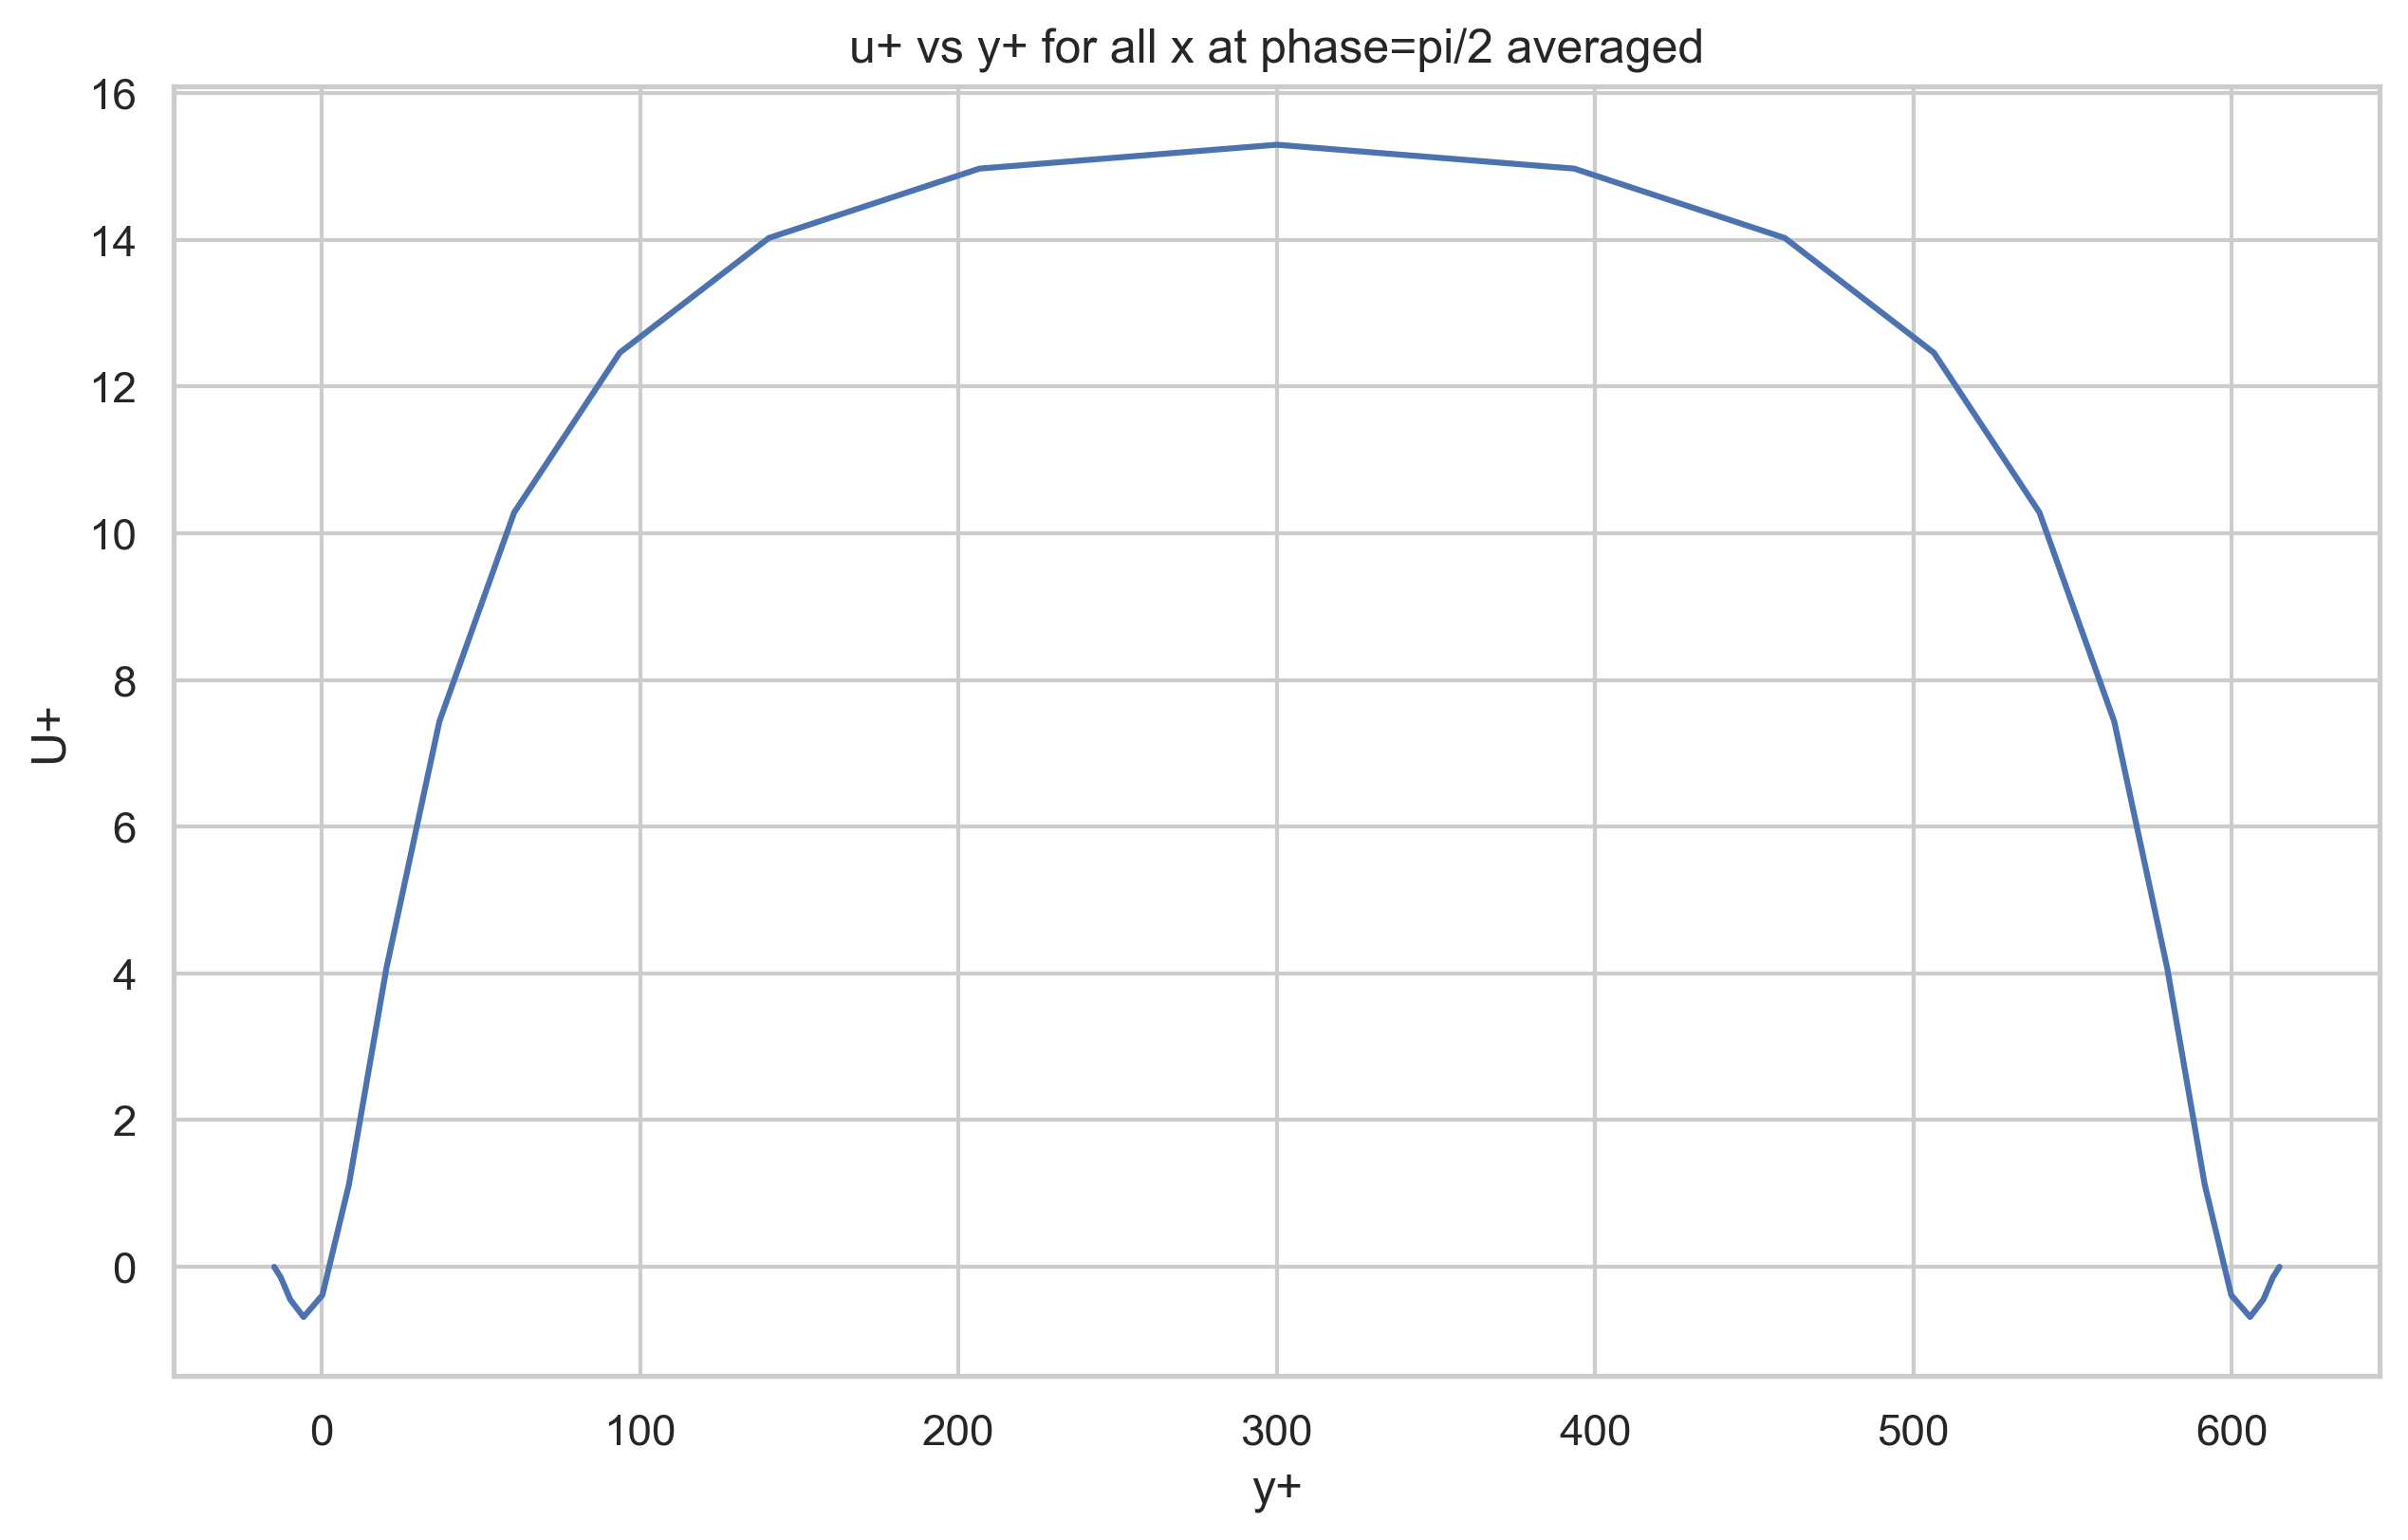

In [14]:

#interpolation in x only by the corresponding node(chosen) plus phase averaged
def build_symmetric_y_grid(y_min, y_max, l1, r, n):
    spacing_half = [l1 * r**(i) for i in range(n)]
    spacing = np.array(spacing_half + spacing_half[::-1])
    spacing_scaled = spacing / spacing.sum() * (y_max - y_min)
    y_points = np.cumsum(spacing_scaled) + y_min  # Start from y_min directly
    y_points = np.insert(y_points, 0, y_min)
    return y_points  # Remove the insert operation

def interpolate_U_at_x(x_val, df, unique_x, l1, r, n):
    x_below = unique_x[unique_x < x_val].max(initial=None)
    x_above = unique_x[unique_x > x_val].min(initial=None)
    if x_below is None or x_above is None:
        return None

    sub_below = df[df['x_rounded'] == x_below].sort_values('y').reset_index(drop=True)
    sub_above = df[df['x_rounded'] == x_above].sort_values('y').reset_index(drop=True)

    y_min = -0.05 * np.sin(16 * x_val)
    y_max =  2.0 + 0.05 * np.sin(16 * x_val)
    y_interp = build_symmetric_y_grid(y_min, y_max, l1, r, n)
    y_plus=y_interp*u_tau/nu

    if len(sub_below) < 2*n+1 or len(sub_above) < 2*n+1:
        return None

    U_below = sub_below['U']
    U_above = sub_above['U']
    U_interp = U_below + (U_above - U_below) * (x_val - x_below) / (x_above - x_below)
    U_plus=U_interp/u_tau

    return pd.DataFrame({'y_plus': y_plus, 'U_plus': U_plus})

#plotting average
all_data = []

for x_val in x_sel:
    if x_val in unique_x:
        subset = df[df['x_rounded'] == x_val].copy()
        subset['y_plus'] = subset['y'] * u_tau / nu
        subset['U_plus'] = subset['U'] / u_tau
        subset = subset[['y_plus', 'U_plus']]
    else:
        subset = interpolate_U_at_x(x_val, df, unique_x, l1, r, n)
    if subset is not None:
        subset['y_plus'] = subset['y_plus'].round(3)
        all_data.append(subset)

# Concatenate and average
combined_df = pd.concat(all_data)
avg_df = combined_df.groupby('y_plus', as_index=False)['U_plus'].mean()
plt.figure(figsize=(10, 6), dpi=300)
sns.lineplot(data=avg_df, x='y_plus', y='U_plus')
# === Plotting ===
#plt.figure(figsize=(10, 6), dpi=300)
#for x_val in x_sel:
 #   if x_val in unique_x:
  #      subset = df[df['x_rounded'] == x_val].sort_values('y')
   #     sns.lineplot(x='y_plus', y='U_plus', data=subset, label=f'x={x_val:.3f}')
    #else:
     #   interp_df = interpolate_U_at_x(x_val, df, unique_x, l1, r, n)
      #  if interp_df is not None:
       #     sns.lineplot(x='y_plus', y='U_plus', data=interp_df, label=f'x={x_val:.3f}*')

plt.title(f'u+ vs y+ for all x at phase=pi/{pi_div} averaged')
plt.xlabel('y+')
plt.ylabel('U+')
plt.grid(True)
plt.show()


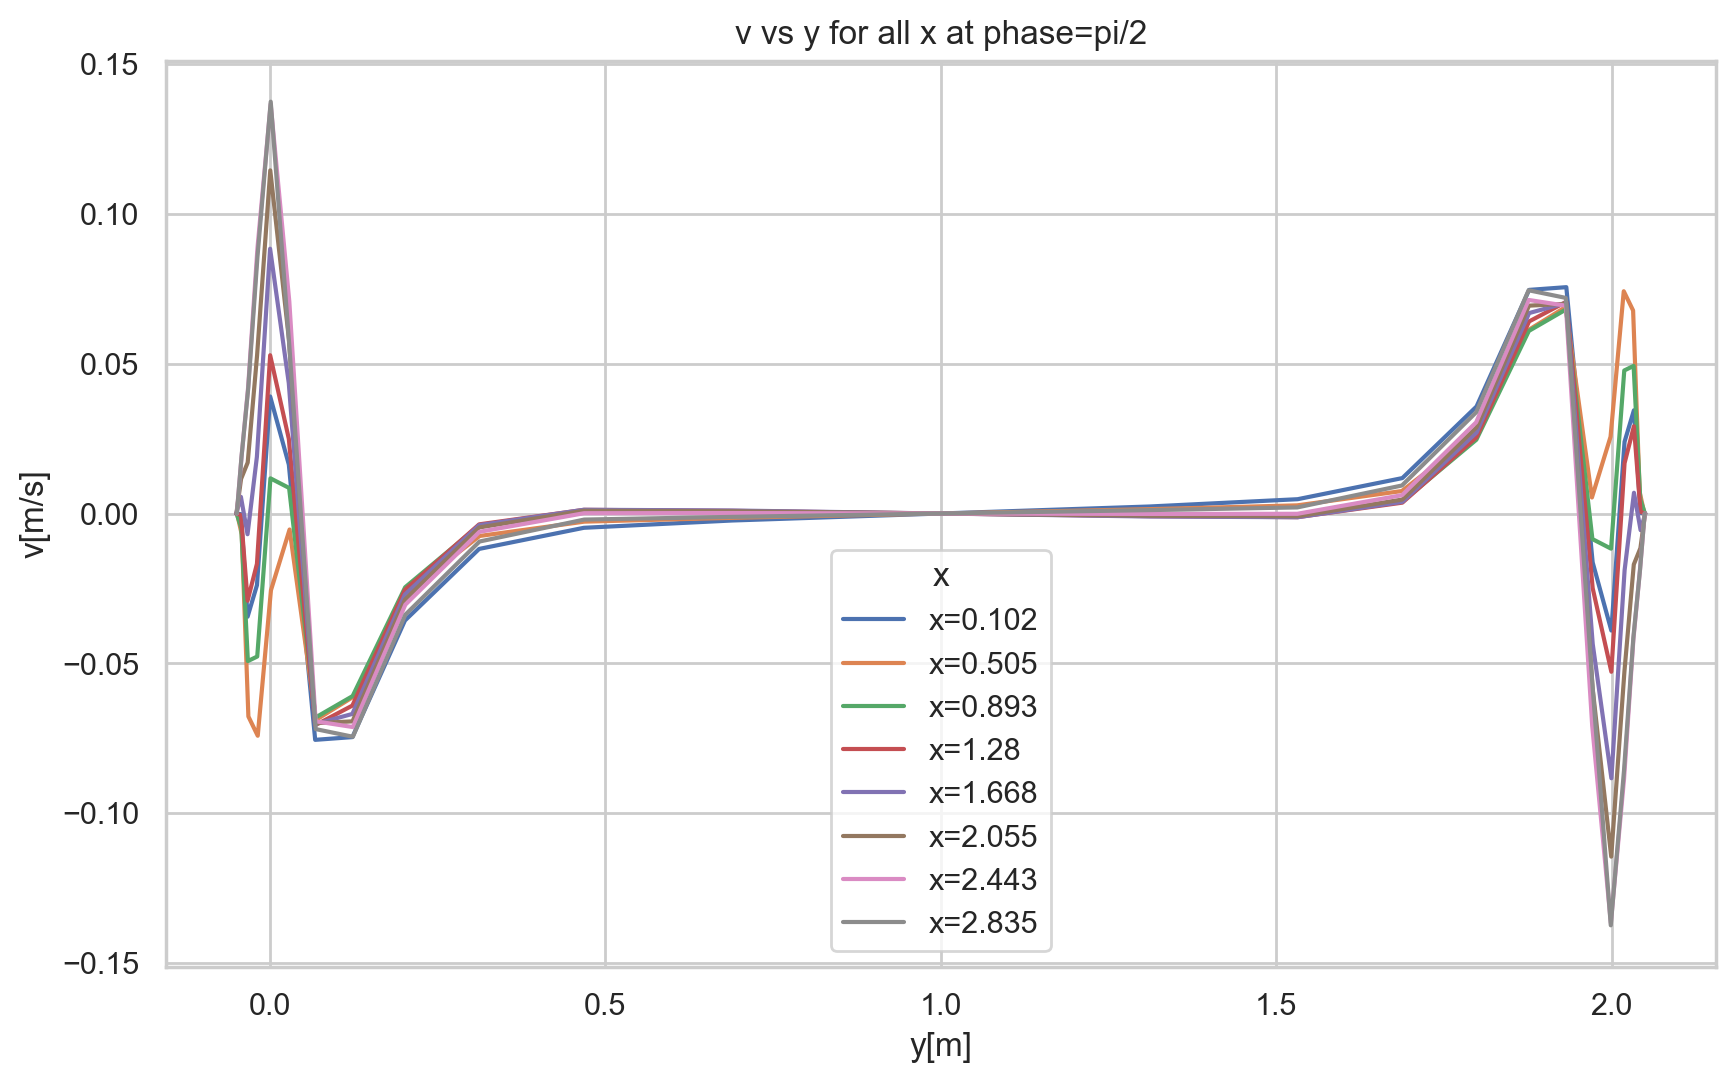

In [15]:
#no interpolatin involved
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6),dpi=200)


for x_val in sorted(node_sel):
    subset = df[df['x_rounded'] == x_val]
    sns.lineplot(x='y', y='v', data=subset, label=f'x={x_val}')

plt.title(f'v vs y for all x at phase=pi/{pi_div}')
plt.xlabel('y[m]')
plt.ylabel('v[m/s]')
plt.legend(title='x')
plt.show()

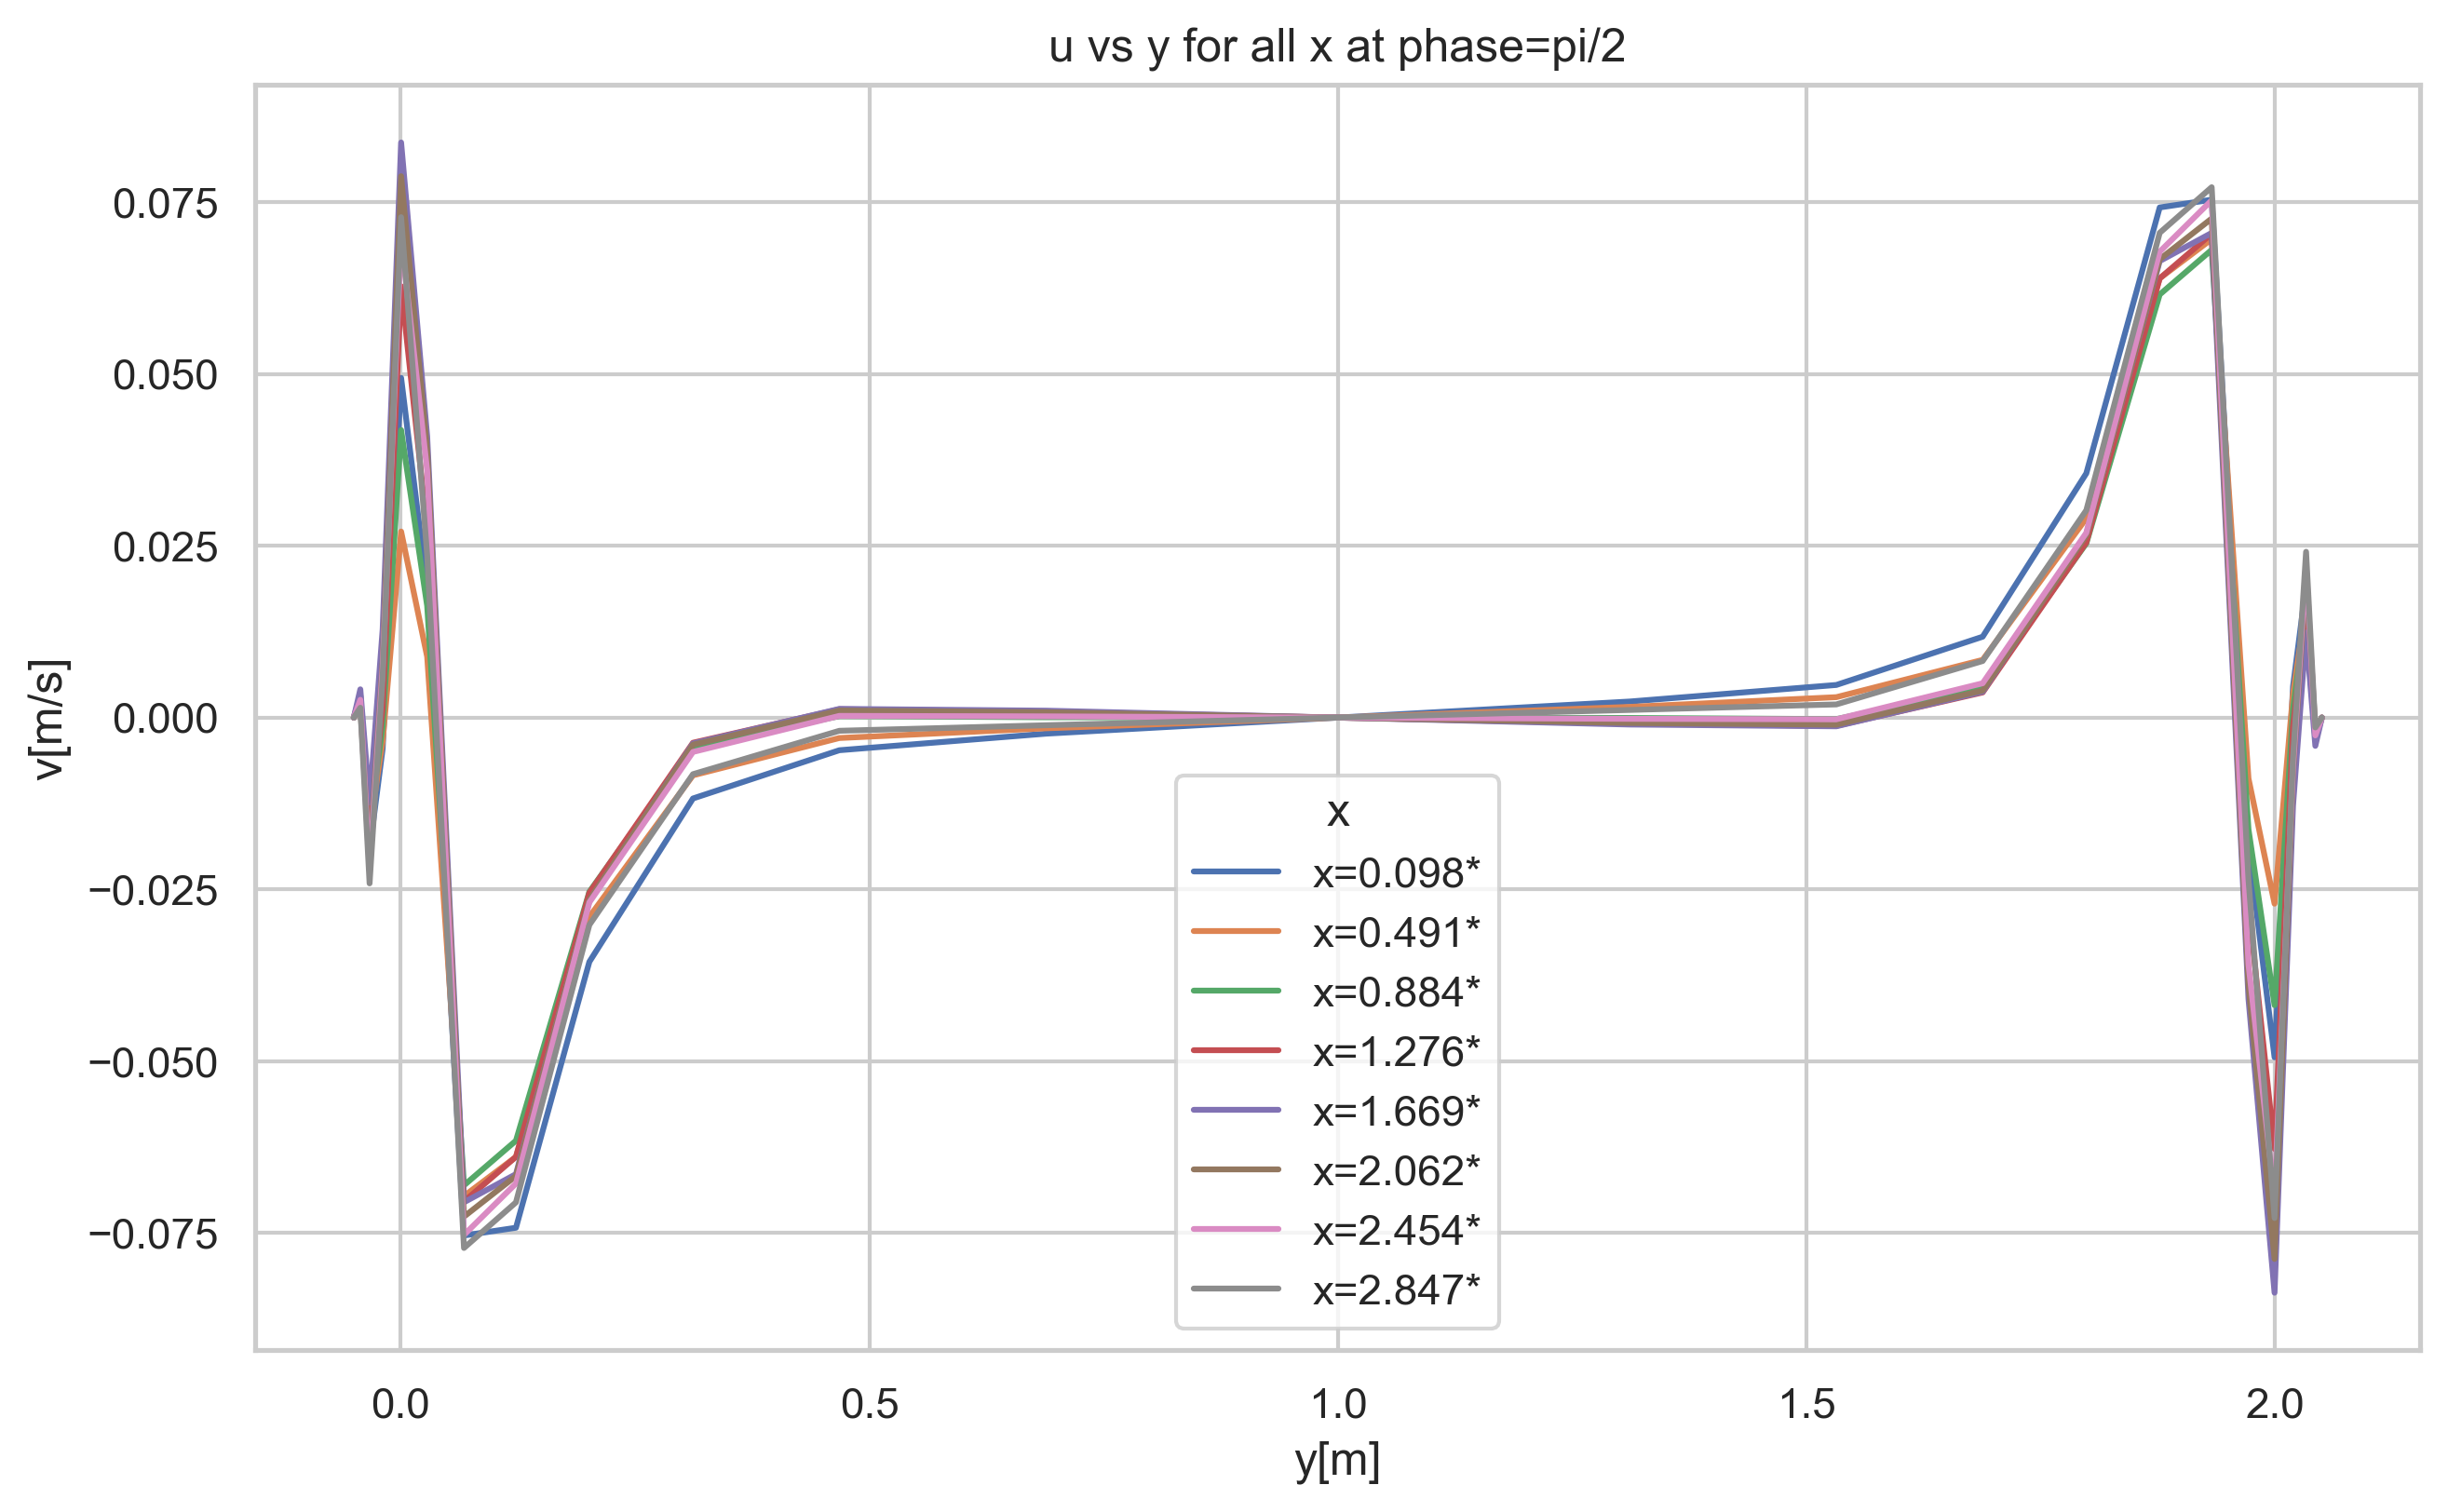

In [16]:
#interpolation in x only by the corresponding node(chosen)
def build_symmetric_y_grid(y_min, y_max, l1, r, n):
    spacing_half = [l1 * r**(i) for i in range(n)]
    spacing = np.array(spacing_half + spacing_half[::-1])
    spacing_scaled = spacing / spacing.sum() * (y_max - y_min)
    y_points = np.cumsum(spacing_scaled) + y_min  # Start from y_min directly
    y_points = np.insert(y_points, 0, y_min)
    return y_points  # Remove the insert operation

def interpolate_U_at_x(x_val, df, unique_x, l1, r, n):
    x_below = unique_x[unique_x < x_val].max(initial=None)
    x_above = unique_x[unique_x > x_val].min(initial=None)
    if x_below is None or x_above is None:
        return None

    sub_below = df[df['x_rounded'] == x_below].sort_values('y').reset_index(drop=True)
    sub_above = df[df['x_rounded'] == x_above].sort_values('y').reset_index(drop=True)

    y_min = -0.05 * np.sin(16 * x_val)
    y_max =  2.0 + 0.05 * np.sin(16 * x_val)
    y_interp = build_symmetric_y_grid(y_min, y_max, l1, r, n)

    if len(sub_below) < 2*n+1 or len(sub_above) < 2*n+1:
        return None

    v_below = sub_below['v']
    v_above = sub_above['v']
    v_interp = v_below + (v_above - v_below) * (x_val - x_below) / (x_above - x_below)

    return pd.DataFrame({'y': y_interp, 'v': v_interp})


# === Plotting ===
plt.figure(figsize=(10, 6), dpi=300)
for x_val in x_sel:
    if x_val in unique_x:
        subset = df[df['x_rounded'] == x_val].sort_values('y')
        sns.lineplot(x='y', y='v', data=subset, label=f'x={x_val:.3f}')
    else:
        interp_df = interpolate_U_at_x(x_val, df, unique_x, l1, r, n)
        if interp_df is not None:
            sns.lineplot(x='y', y='v', data=interp_df, label=f'x={x_val:.3f}*')

plt.title(f'u vs y for all x at phase=pi/{pi_div}')
plt.xlabel('y[m]')
plt.ylabel('v[m/s]')
plt.grid(True)
plt.legend(title='x')
plt.show()

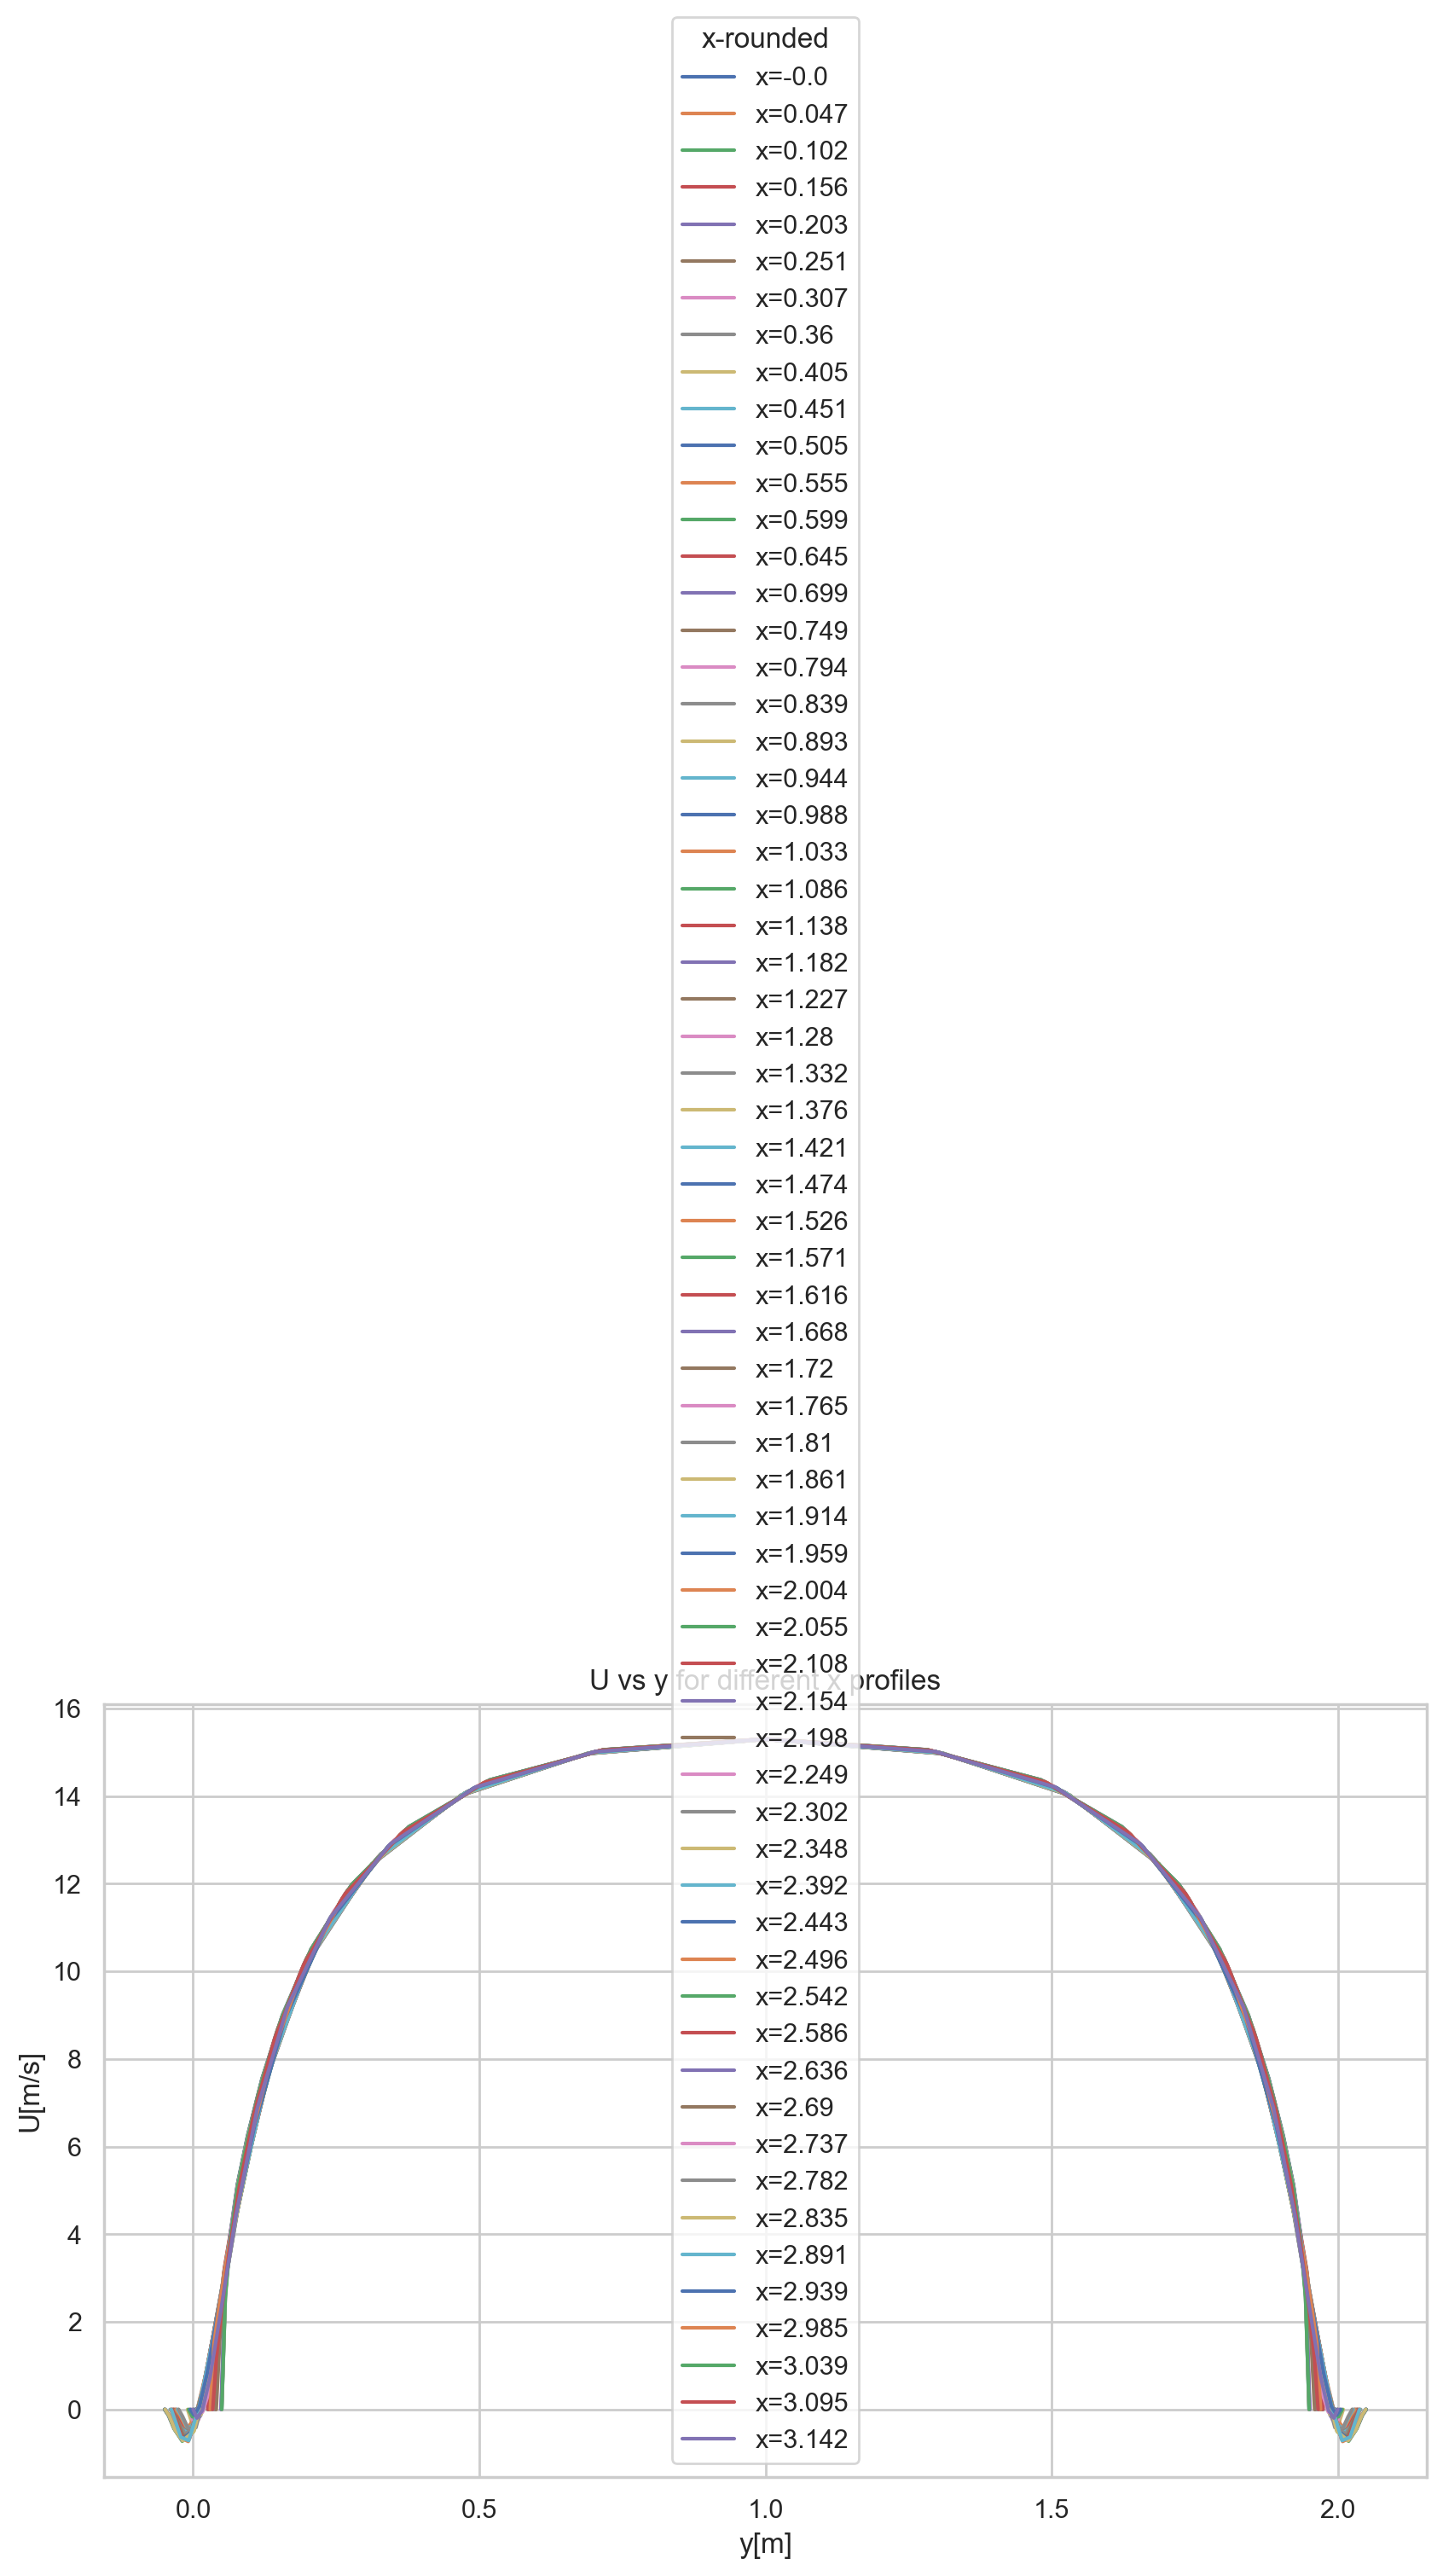

In [17]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6),dpi=200)


# Group by rounded x to 1 decimal place and plot U vs y for each group
for x_val in sorted(df['x_rounded'].unique()):
    subset = df[df['x_rounded'] == x_val]
    sns.lineplot(x='y', y='U', data=subset, label=f'x={x_val}')

plt.title('U vs y for different x profiles')
plt.xlabel('y[m]')
plt.ylabel('U[m/s]')
plt.legend(title='x-rounded')
plt.show()

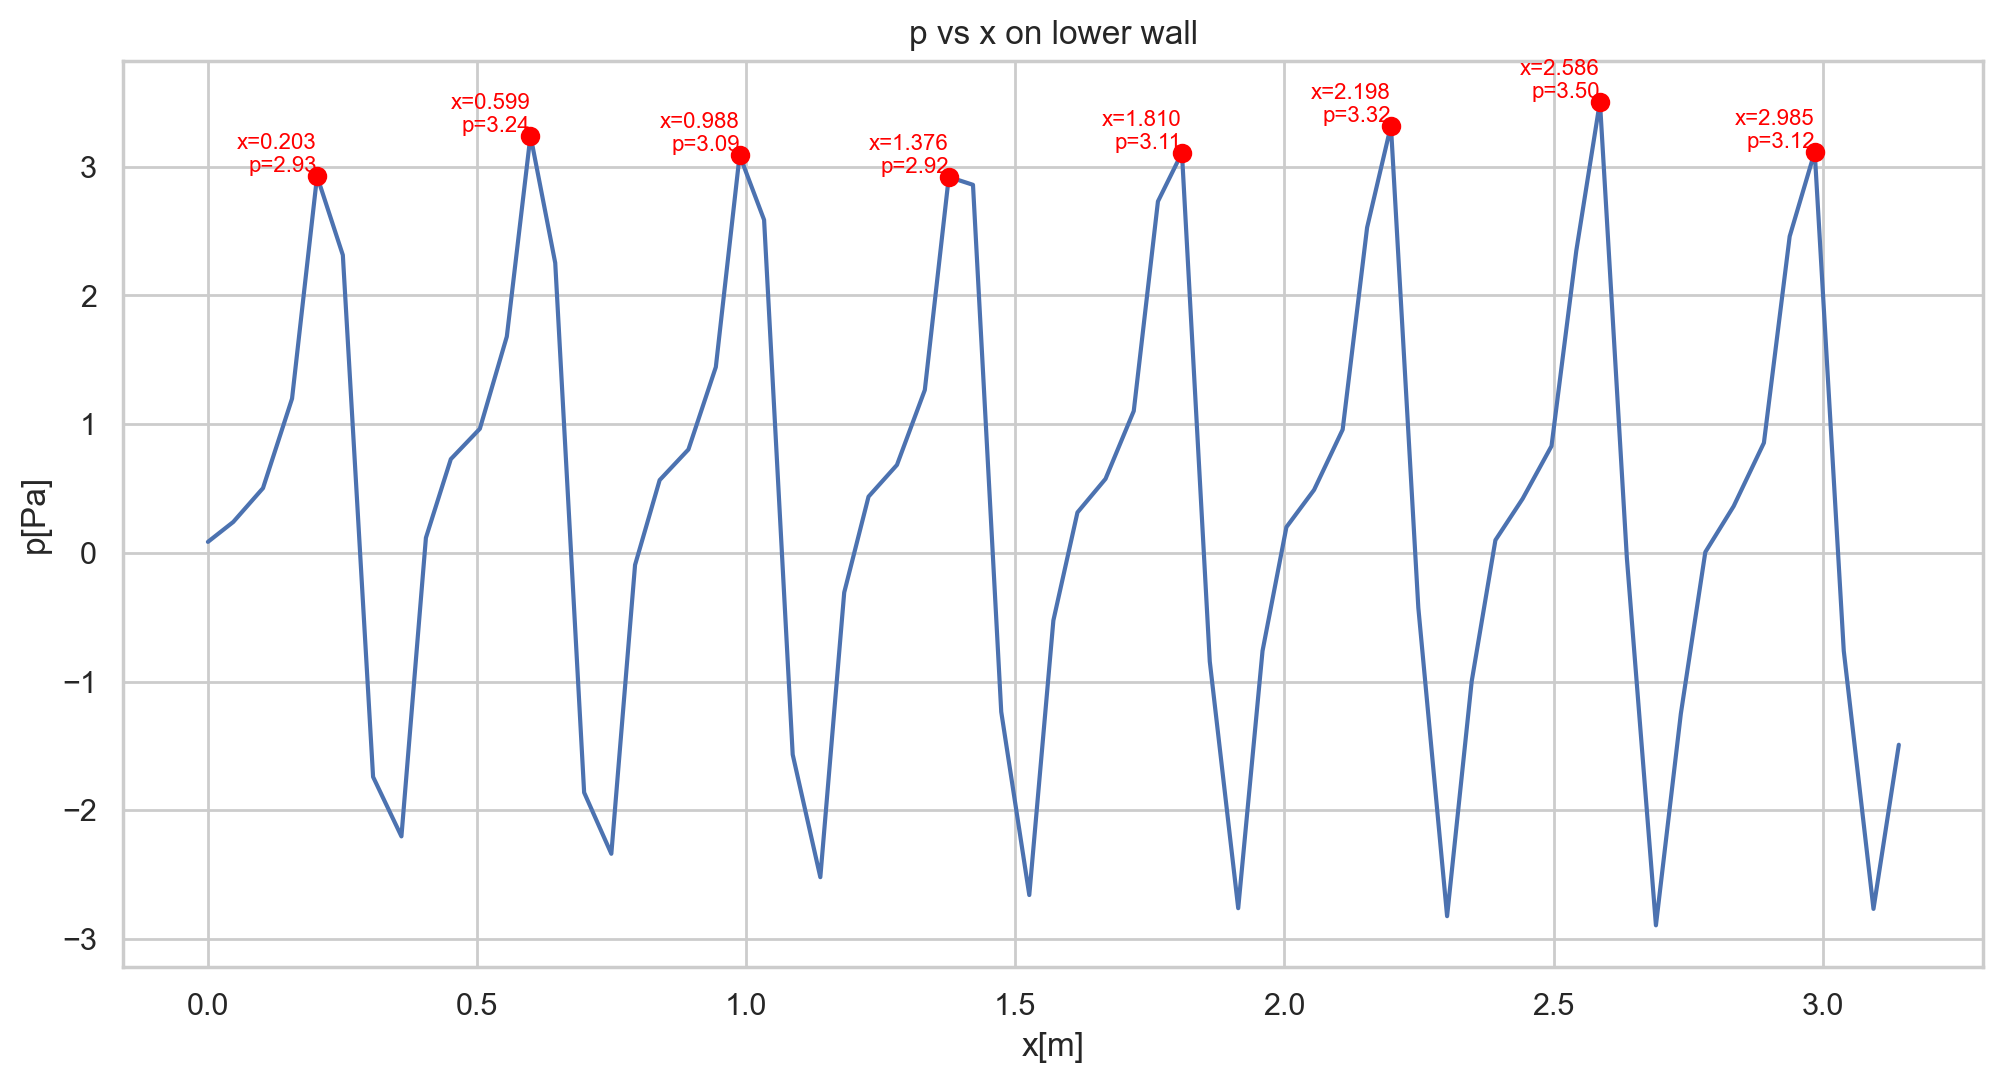

In [18]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6),dpi=200)

#find stagnation point
df_lower_wall = df.loc[df.groupby('x_rounded')['y'].idxmin()]
df_lower_wall = df_lower_wall.sort_values('x')

# Step 2: Plot full line
sns.lineplot(x='x', y='p', data=df_lower_wall)
plt.title('p vs x on lower wall')
plt.xlabel('x[m]')
plt.ylabel('p[Pa]')

# Step 3: Slice into periods and find max point per period
periods = {}
for i in range(1, periods_number + 1):  # i from 1 to N
    start = 1 + node_period * (i - 1)
    end = 1 + node_period * i
    periods[f'period{i}'] = df_lower_wall.iloc[start:end]

    period_df = periods[f'period{i}']
    max_idx = period_df['p'].idxmax()
    max_row = period_df.loc[max_idx]

    # Plot dot
    plt.scatter(max_row['x'], max_row['p'], color='red', zorder=5)

    # Annotate
    plt.text(max_row['x'], max_row['p'],
         f"x={max_row['x']:.3f}\np={max_row['p']:.2f}",
         color='red', fontsize=8,
         ha='right', va='bottom')
plt.grid(True)
plt.show()
   
                       